# Interbrain networks
***Authors: Christian Gerloff, Vanessa Reindl***

With this notebook, we would like to showcase interbrain networks and an interpretable network embedding based on graph topological properties proposed in Gerloff et al. 2022.

For illustration purposes, we reduced and simplified the code base which was originaly deployed on HPC. For preprocessing, connectivity estimation, inference with multivariate Bayesian hierarchical models and detailed evaluation strategies, we would like to refer the reader to the paper.


## Imports & data loader
First, we import the underlying modules and packages. Further, we specify directories where we aim to store relevant data.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from pathlib import Path
from IPython.display import Image

from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from interbrainnetworks.networks import Networks, create_testdata
from interbrainnetworks.networks import calculate_topologies
from interbrainnetworks.embeddings import NetworkEmbedding, Embedding

PATH = Path.cwd().parent / 'data'
PATH_ASSETS = Path.cwd().parent / 'assets'
PATH_CONNECTIVITY = PATH / 'connectivity'
PATH_GRAPHS = PATH / 'graphs'
COORDINATES_FILENAME = 'channel2mni.csv'

The Python package you are importing, AtlasReader, is licensed under the
BSD-3 license; however, the atlases it uses are separately licensed under more
restrictive frameworks.
By using AtlasReader, you agree to abide by the license terms of the
individual atlases. Information on these terms can be found online at:
https://github.com/miykael/atlasreader/tree/master/atlasreader/data



To illustrate the network generation and embedding, we create some synthetic toy data. In each of the 30 sessions, functional connectivity between different `partners` is randomly generated. We generate two task blocks and one rest block. Please note that the procedure for generating the data does not simulate meaningful estimators or network topologies.

In [2]:
filenames = create_testdata(n_samples=30, path=PATH_CONNECTIVITY)
(task_actual_filename, rest_actual_filename,
 task_shuffled_filename, rest_shuffled_filename) = filenames

Next, we specify parameters. Importantly, we set the `exchangeable` parameter which defines the fixed variables for the graph reduction procedure (see Graph construction, reduction and stratification).

In [3]:
params = {
    'chromophore': 'Hbo',
    'atlas': 'default',
    'channel_set': 22,
    'input_connectivity_estimator': 'salient_wco',
    'condition_filter': [],
    'partner_filter': [],
    'id_filter': [],
    'blocks': ['Block_1', 'Block_2', 'Block_0'],
    'separated_estimators': True,
    'factors_scaling': ['channel_pair'],
    'connectivity_scaling': True,
    'exchangeables': ['channel_pair', 'Condition', 'Partner'],
    'alpha': 0.05,
}

To visualize the positions of the channels, we read the MNI coordinates of each channel.

In [4]:
mni = pd.read_csv(PATH / COORDINATES_FILENAME,
                  dtype={'Channel': np.int32,
                         'X': np.float64,
                         'Y': np.float64,
                         'Z': np.float64,
                         'Area': 'str'},
                   header=0,
                   index_col=0)

Next, we read the synthetic task and rest data of the participants.

In [5]:
task = pd.read_parquet(task_actual_filename)
rest = pd.read_parquet(rest_actual_filename)

We prepare the data to generate a bipartite graph.
A bipartite graph consists of two set of nodes. Each set represents the brain regions of one subject of the dyad.

In [6]:
actual_pairs = Networks('actual', **params)
actual_pairs.set_data(task, rest, mni)

## Graph construction, reduction and stratification for non-interaction related confounds

A challenge in graph-based analysis is the reduction of complete graphs to avoid false-positive effects of spurious connectivity. A common approach to address this issue is proportional thresholding. However, the choice of meaning full threshold remains challenging. 

In the paper, we propose a graph reduction procedure based on blockwise permutation of signals from non-interaction partners (shuffled / random pairs). This procedure draws on the conceptual design of hyperscannig as it provides a natural control for non-interaction related neural synchrony and allows to stratify for confounds already during the graph construction. By defining the `exchangables`, a stratification for experiment-specific confounds is enabled.

As a side note, here we also exemplified the use of a scaling factor. In case `connectivity_standardized` is `True`, the weights of fully connected graphs can be scaled. As several generic graph embeddings from the machine learning domain rely on weights of weakly connected graphs, these embeddings cannot always be applied to such reduced graphs. Hence, scaling can be performed.

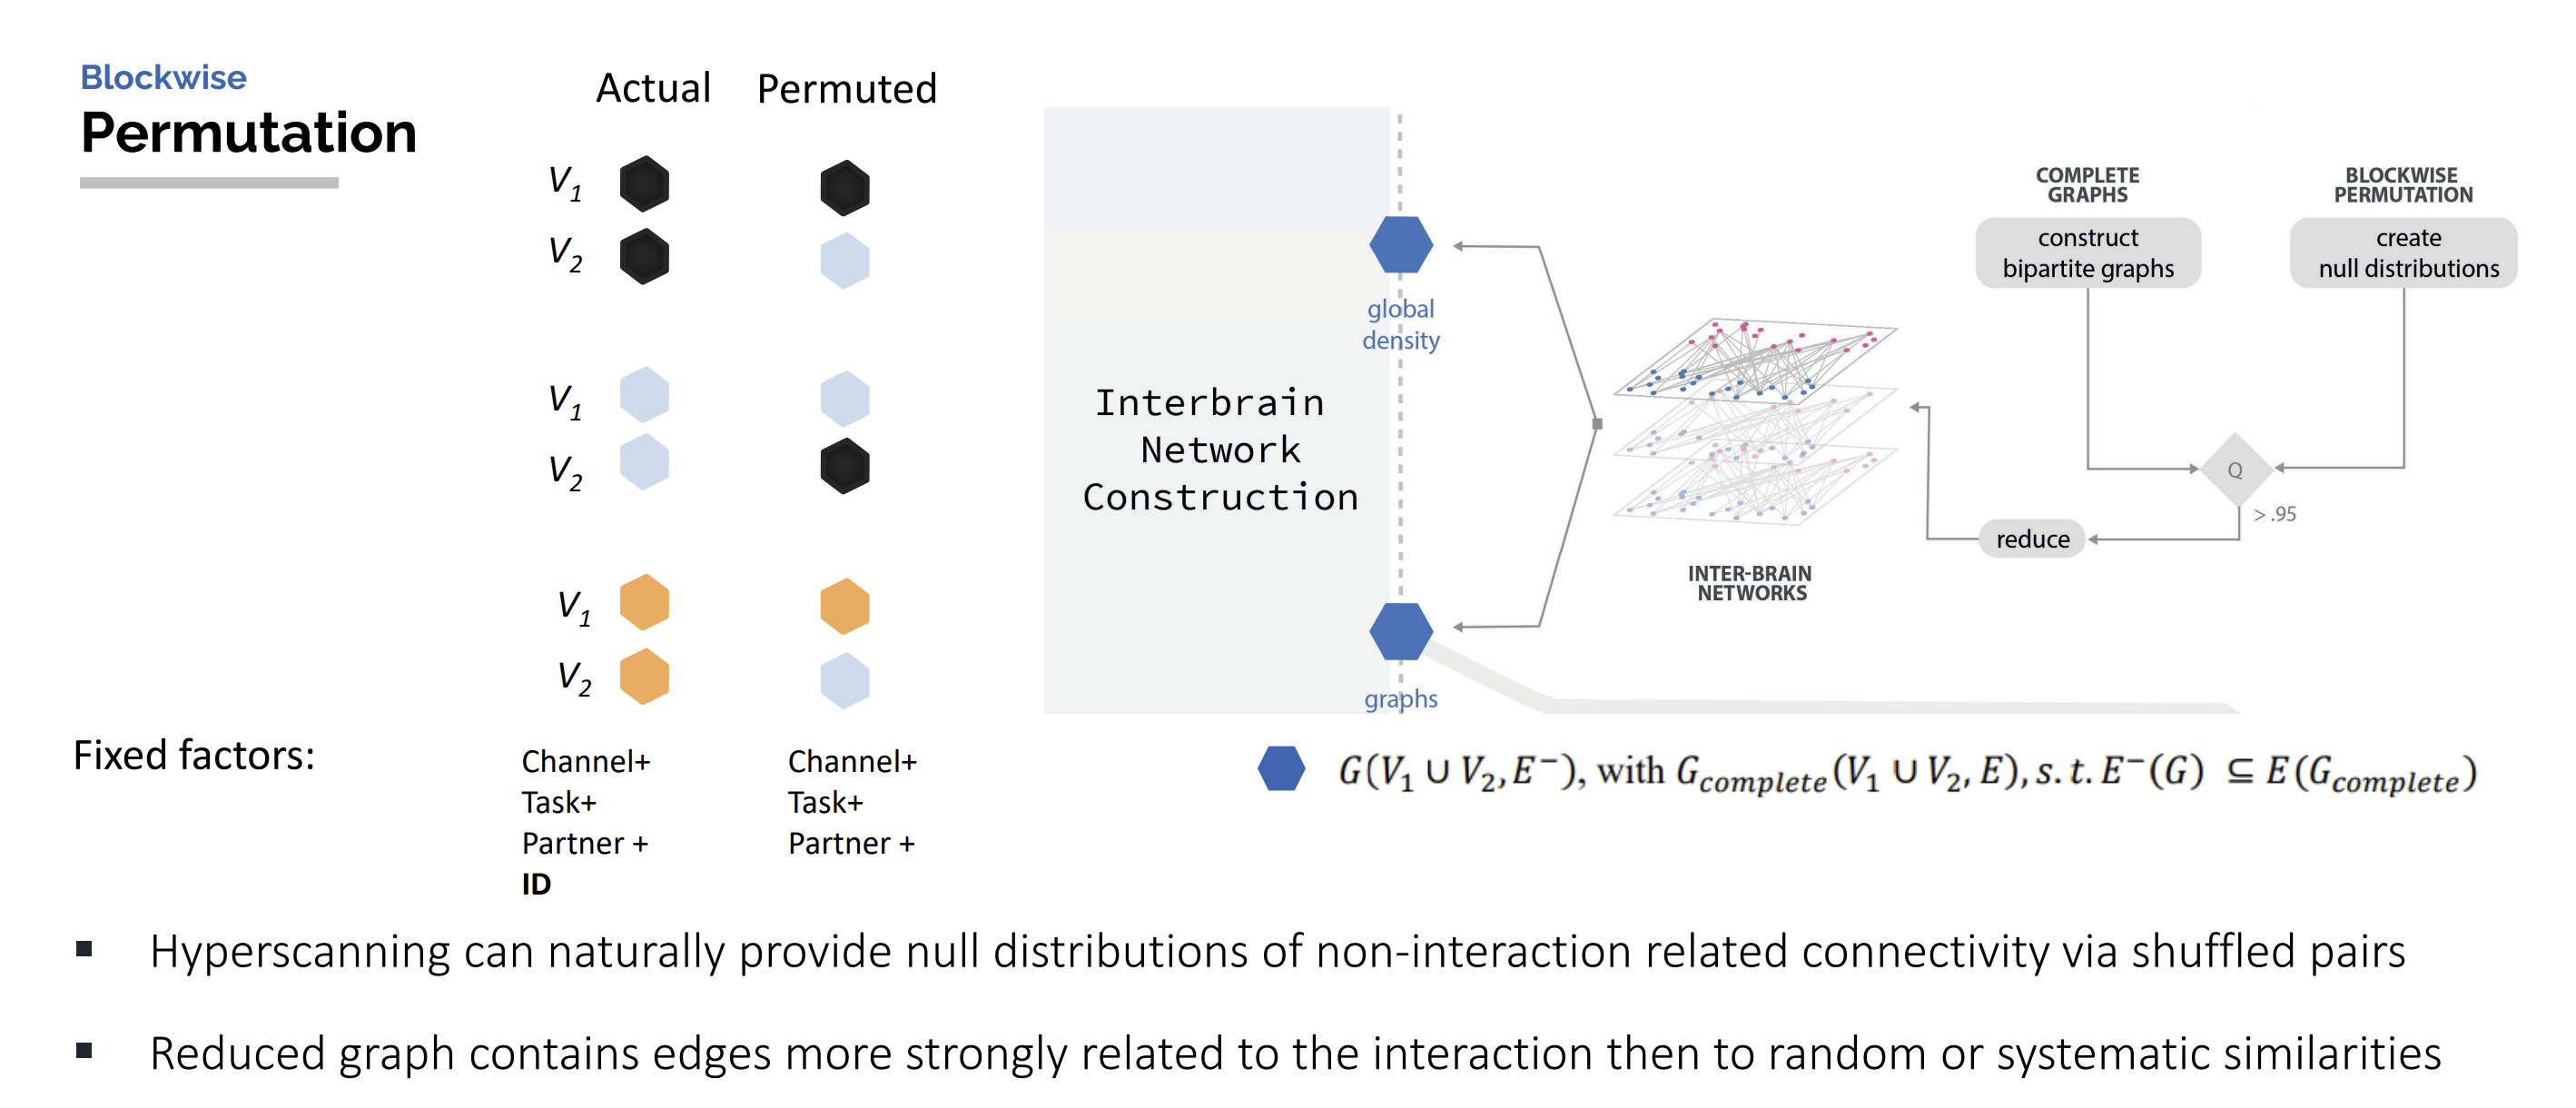

In [7]:
Image(PATH_ASSETS / 'graph_reduction.png')

In [8]:
task = pd.read_parquet(task_shuffled_filename)
rest = pd.read_parquet(rest_shuffled_filename)
shuffled_pairs = Networks('permu', **params)
shuffled_pairs.set_data(task, rest, mni)
shuffled_pairs.scale()
mean_estimators = shuffled_pairs.scaling_factor
actual_pairs.transform(shuffled_pairs.data, mean_estimators)

From the resulting null distributions, we can plot the values (here alpha=0.05) that determine the connectivity that should be achieved to express edges beyond non-interaction related synchrony. In this example, we determined these thresholds per block. Below we illustrated the resulting boundaries for some channel pairs.

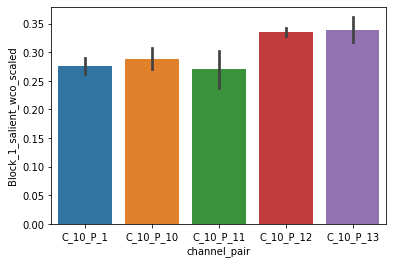

In [9]:
channel_pairs = actual_pairs._null_dist_threshold['channel_pair'].unique()[0:5]
task_data = actual_pairs._null_dist_threshold[
    (actual_pairs._null_dist_threshold['Condition'] != 'rest') &
    (actual_pairs._null_dist_threshold['channel_pair'].isin(channel_pairs))
]
ax = sns.barplot(x='channel_pair',
                 y='Block_1_salient_wco_scaled',
                 data=task_data)

Subsequently, we construct the reduced bipartite interbrain networks and compute the graph metrics.

In [10]:
graph_results = pd.DataFrame()

task_results = actual_pairs.data.loc[actual_pairs.data.Condition != 'rest', :]
rest_results = actual_pairs.data.loc[actual_pairs.data.Condition == 'rest', :]

# graphs based on task blocks
for i in actual_pairs.block_estimators_scaled[0:2]:
    task = calculate_topologies(task_results,
                                i,
                                path=PATH_GRAPHS).compute()
    graph_results = pd.concat([graph_results, task])

# graphs based on rest blocks
rest_estimator = actual_pairs.block_estimators_scaled[2]
rest_results = calculate_topologies(rest_results,
                                    rest_estimator,
                                    path=PATH_GRAPHS).compute()
graph_results = pd.concat([graph_results, rest_results])

# save results
graph_results.to_pickle(PATH_GRAPHS / 'actual_graphs.pkl')

In [11]:
graph_results.groupby('partner').count()

graph_id  ID  conditions  estimator  graph_type  weights  pos  \
partner                                                                   
peer            87  87          87         87          87       87   87   
stranger        87  87          87         87          87       87   87   

          metric  n_possible_edges  probe_1  baseline  condition  filename  
partner                                                                     
peer          87                87       87        87         87        87  
stranger      87                87       87        87         87        87

One of the resulting bipartite graphs is shown below.

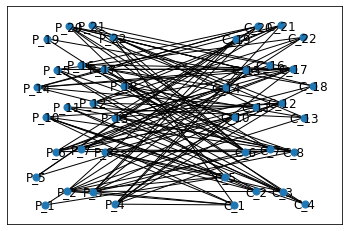

In [12]:
filename = graph_results.iloc[0].filename
pos = graph_results.iloc[0].pos
graph = nx.read_gexf(PATH_GRAPHS / filename)
nx.draw_networkx(graph,
                 pos=pos,
                 with_labels=True,
                 node_size=50)

If you compare different graphs, you may notice that not all channels are displayed. In EEG and fNIRS, it is common to exclude unreliable channels ("bad channel"). This can bias specific graph metrics because the excluded bad channels affect the size and topology of the graph. Therefore, we correct for the number of possible edges (see Gerloff et al. 2022).

# Interbrain network embedding

To overcomes challenges in nodal topology-based 
analysis and to enable inferential and predictive applications, we used network embeddings(e.g. Graph2Vec). Futher, we proposed an NMF-based embedding that preserves the topological properties of interbrain networks and encodes how synchrony patterns are seeded in specific brain regions.


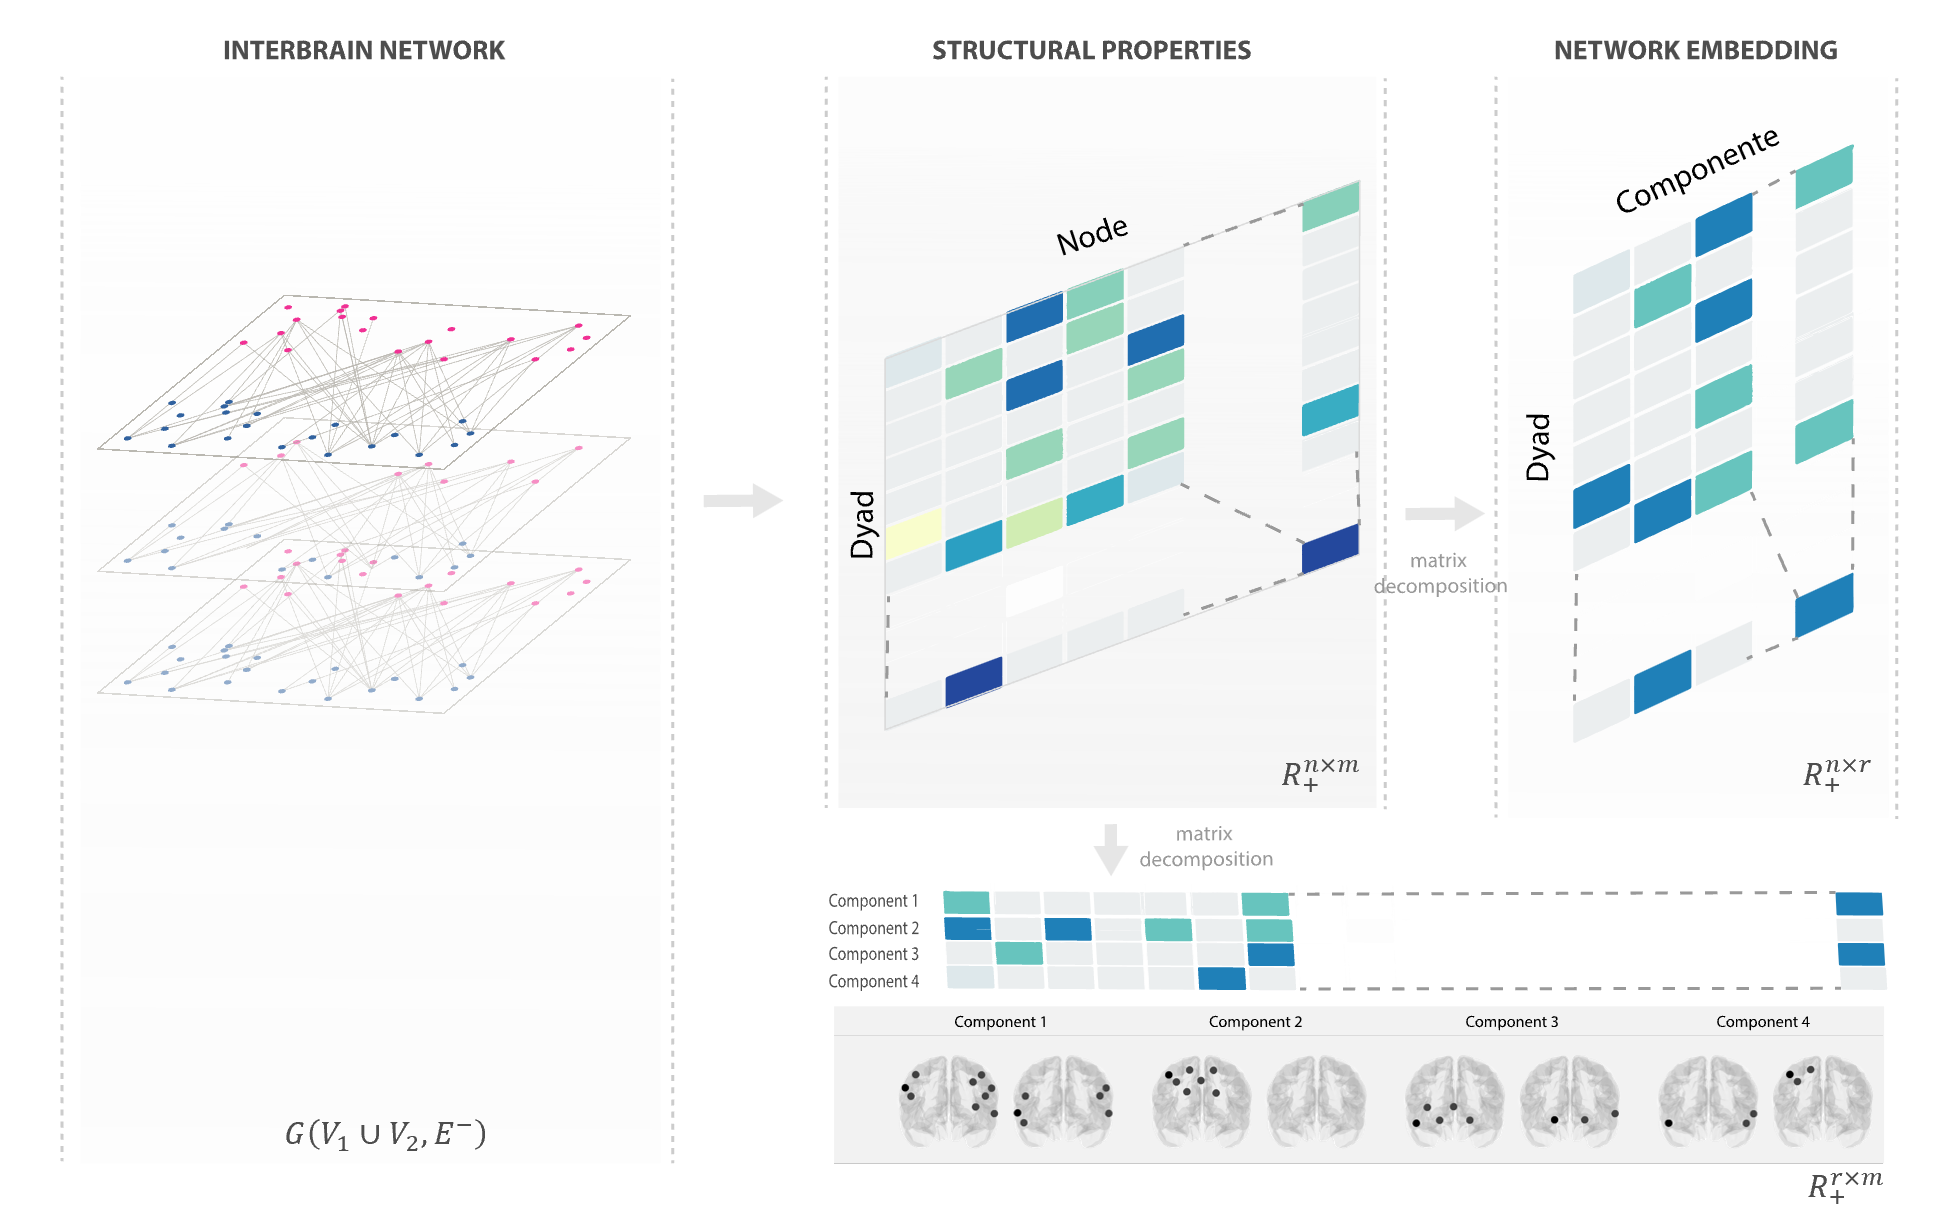

In [13]:
Image(PATH_ASSETS / 'concept_embedding.png')

Here we specify and fit the embedding.

In [14]:
ibn = Embedding()
network_embeddings = NetworkEmbedding(ibn)
network_embeddings.fit_transform(graph_results['metric'],
                                 graph_results['partner'],
                                 graph_results['graph_id'],
                                 path=PATH_GRAPHS)

### Interpretability

One advantage of the proposed framework is its interpretability.
The NMF-based embedding provides a kind of lookup table that describes which regions contribute to the embedding space (/components of the embedding).


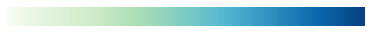

In [15]:
participant_1, participant_2 = network_embeddings.plot_lookup(
    feature=1,
    threshold=0.5,
    mni=actual_pairs.coordinates
)
participant_1

In [16]:
participant_2

### Directed and undirected connectivity and graphs
Here we exemplified interbrain networks for undirected connectivity estimators such as the bivariate Wavelet coherence.
However, in other settings, we might be interested in examining the directionality of synchrony between subjects. In such a case, directed estimators can be calculated and the graph can be formulated based on these directed estimators (for more information see Gerloff et al. 2022).

# Application example

***Inference:*** This interpretable embedding can be used to gain insights on both the global and nodal level for inferential research questions. In Gerloff et al. 2022, we implemented a `multivariate Bayesian Hierarchical model`. Reindl et al 2022 applied this approach in a multimodal setting.

***Prediction:*** Moreover, the embedding can be applied to predict effects or phenotypes on an individual level.

### Prediction via interbrain network embeddings
Here we illustrate a prediction of the interaction partner via a simple, repeated train-test split.

***Note:*** The paper provides a more rigorous and thus appropriate evaluation regime:
* repeated, stratified nested cross-validation
* Bayesian hyperparameter optimization
* Additional tests across chromophores
* Comparision to other generic network embeddings (e.g., Graph2Vec) and classifiers.

In [17]:
spit = StratifiedShuffleSplit(n_splits=10, random_state=20211001)

data = graph_results['metric']
labels = graph_results['partner']
obj_embedding = Embedding(n_components=10, seed=20211001)
score = []
for train_idx, test_idx in spit.split(data, labels):
    train, test = data.iloc[train_idx], data.iloc[test_idx]
    labels_train, labels_test = labels.iloc[train_idx], labels.iloc[test_idx]
    
    train_embedding = NetworkEmbedding(obj_embedding)
    test_embedding = NetworkEmbedding(obj_embedding)

    train_embedding.fit_transform(train,
                                  labels_train,
                                  train_idx,
                                  path=PATH_GRAPHS)
    test_embedding.fit_transform(test,
                                 labels_test,
                                 test_idx,
                                 path=PATH_GRAPHS)

    # train a classifier
    clf = LinearSVC().fit(train_embedding.values,
                          train_embedding.label_values)
    pred = clf.predict(test_embedding.values)
    score.append(roc_auc_score(test_embedding.label_values, pred))

print('ROC AUC \n '
      f'mean: {np.mean(score)}'
      f'sd: {np.std(score)}')
    

ROC AUC 
 mean: 0.7944444444444445sd: 0.24222477062879602


### References
Gerloff C, Konrad K, Bzdok D, Büsing C, Reindl V. (2022). Interacting brains revisited: A cross-brain network neuroscience perspective. Human Brain Mapping, [10.1002/hbm.25966](https://doi.org/10.1002/hbm.25966). <br>

Reindl, V., Wass, S., Leong, V., Scharke, W., Wistuba, S., Wirth, C. L., ... & Gerloff, C. (2022). Multimodal hyperscanning reveals that synchrony of body and mind are distinct in mother-child dyads. NeuroImage, 251, 118982, [10.1016/j.neuroimage.2022.118982](https://doi.org/10.1016/j.neuroimage.2022.118982).